# imports

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from osgeo import gdal
import matplotlib.colors
import pickle
import matplotlib.gridspec as gridspec

In [3]:
fold_name = input('Enter Folder Name:\n')

path = '/content/gdrive/MyDrive/MicroDrone/'
fold_path = f'{path}/{fold_name}'

Enter Folder Name:
RF_M2


# Figure 3 - boxenplots of mean prediction errors comparison

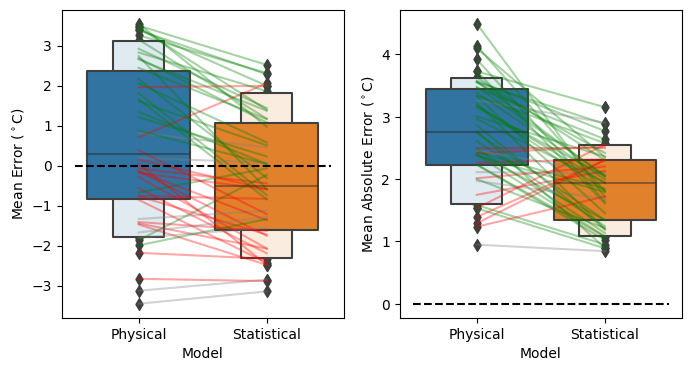

In [4]:
df = pd.read_csv(f'{fold_path}/physical_results_{fold_name}.csv')

fig, axes = plt.subplots(1,2, figsize = (8,4), sharey = False)

for i, param in enumerate(['ME', 'MAE']):
  colors = ['grey' if (abs(df[f'M1_{param}'][i]) - abs(df[f'M2_{param}'][i]) < 0.5 and abs(df[f'M1_{param}'][i]) - abs(df[f'M2_{param}'][i]) > 0) \
            else 'g' if abs(df[f'M1_{param}'][i]) > abs(df[f'M2_{param}'][i]) else 'r' for i in range(len(df))]

  sns.lineplot(data = df[[f'M1_{param}', f'M2_{param}']].T,
              palette = sns.color_palette(colors), alpha = 0.35,
              legend = False, ax = axes[i],
              markers=False, dashes=False,
              #linestyle = '--'
              )
  sns.boxenplot(data = df[[f'M1_{param}', f'M2_{param}']], ax = axes[i])
  axes[i].set_xlabel('Model')#, font="Arial")
  axes[i].set_xticks([0,1], ['Physical', 'Statistical'])#, font="Arial")
  axes[i].set_ylabel(['Mean Error ($^\circ$C)', 'Mean Absolute Error ($^\circ$C)'][i])#, fontname="Arial")
  axes[i].hlines(0, -0.5, 1.5, 'k', '--')
plt.show()

# Figure 4 - prediction error histograms

## A - pixelwise prediction error histograms

pixel_pred_err.csv file contains prediction error for pixels, and cannot upload to github due to size limitations.

<Figure size 1920x1440 with 0 Axes>

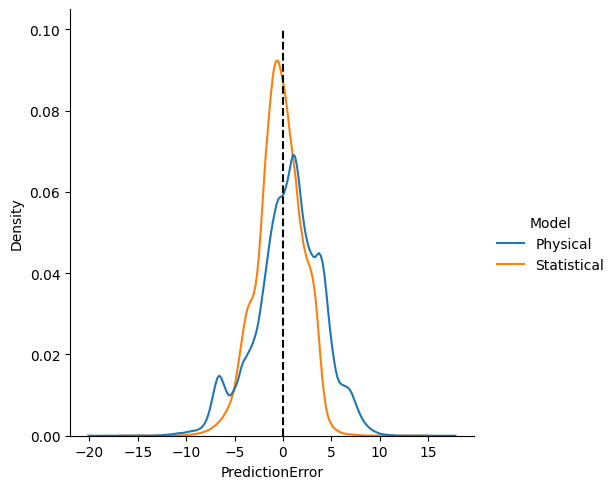

In [5]:
df_me = pd.read_csv(f'{fold_path}/pixel_pred_err.csv')

df_me = df_me[df_me['PredictionError'] < 1000]

plt.figure(dpi = 300)
sns.displot(df_me.sample(30_000_000), x = 'PredictionError', kind = 'kde',
            hue = 'Model', hue_order = ['Physical', 'Statistical'])
plt.vlines(0, 0, 0.1, 'k', '--')
plt.show()

## B - error percent

In [6]:
files = glob.glob(fold_path + '/*RF.npy')

models = []
flights = []
idxs = []
percents = []

for map1 in files:
    name = map1.split('/')[-1][:-13]
    try:
      m1 = glob.glob(f'/content/gdrive/MyDrive/MicroDrone/physical_model/{name}*')[0]
      m2 = glob.glob(f'{fold_path}/{name}_Model_RF.npy')[0]
      fir = glob.glob(f'/content/gdrive/MyDrive/MicroDrone/IR_fixed/{name}*')[0]
      tgi = glob.glob(f'/content/gdrive/MyDrive/MicroDrone/cropped_maps/{name[:-2]}/TGI_{name[-1]}.tif')[0]
    except:
      print(map1)
      continue

    m1_map = gdal.Open(m1).ReadAsArray()
    m2_map = np.load(m2)
    fir_map = np.load(fir) + 273.16
    tgi_map = gdal.Open(tgi).ReadAsArray()

    m1_map[tgi_map > 0.04] = np.nan
    m2_map[tgi_map > 0.04] = np.nan
    fir_map[tgi_map > 0.04] = np.nan

    m1_pe = abs(m1_map - fir_map)
    m2_pe = abs(m1_map - m2_map - fir_map)

    start_m1 = len(m1_pe[np.isnan(m1_pe)]) / (1024**2)
    start_m2 = len(m2_pe[np.isnan(m2_pe)]) / (1024**2)
    per_m1 = [0]*12
    per_m2 = [0]*12

    for i in range(1,11):
      m1_pe[m1_pe < i] = np.nan
      count1 = len(m1_pe[np.isnan(m1_pe)]) / (1024**2 - start_m1)
      per_m1[i] += count1

      m2_pe[m2_pe < i] = np.nan
      count2 = len(m2_pe[np.isnan(m2_pe)]) / (1024**2 - start_m2)
      per_m2[i] += count2

    per_m1[11] += len(m1_pe[np.isnan(m1_pe)]) / (1024**2 - start_m1)
    per_m2[11] += len(m2_pe[np.isnan(m2_pe)]) / (1024**2 - start_m2)

    models += ['Model1'] * 12 + ['Model2']*12
    flights += [name] * 24
    idxs += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '>10'] * 2
    percents += per_m1 + per_m2

df_per = pd.DataFrame({'Model': models, 'Flights': flights, 'ErrorRange': idxs, 'ErrorPercent': percents})
df_per['ErrorPercent'] = df_per['ErrorPercent']*100

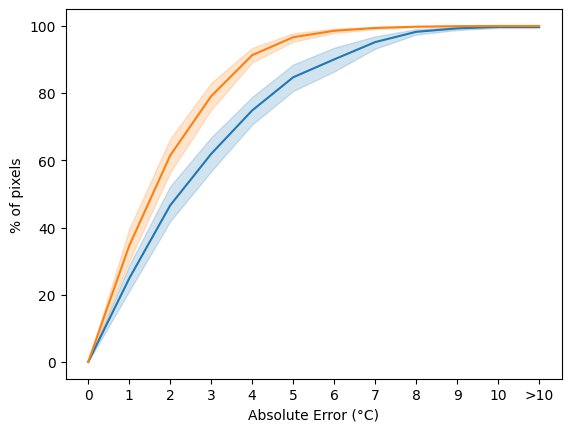

In [7]:
sns.lineplot(data = df_per, x = 'ErrorRange', y = 'ErrorPercent',
             hue = 'Model', legend = False)
plt.xlabel('Absolute Error (\u00b0C)')
plt.ylabel('% of pixels')
plt.show()

# Figure 6 - prediction error and input variables correlations

In [8]:
d = {'TGI': [], 'Height': [], 'Shade': [], 'RealSolar': [], 'Skyview': [],
     'Phy': [], 'M1': [], 'M2': []}

files = [f.split('/')[-1][:-13] for f in glob.glob(fold_path + '/*RF.npy')]
for name in files:
  rand = np.random.choice(1024**2, 1000, replace = False)
  d['TGI'] += list(gdal.Open(f'/content/gdrive/MyDrive/MicroDrone/cropped_maps/{name[:-2]}/TGI_{name[-1]}.tif').ReadAsArray().flatten()[rand])
  d['Height'] += list(gdal.Open(f'/content/gdrive/MyDrive/MicroDrone/cropped_maps/{name[:-2]}/height_{name[-1]}.tif').ReadAsArray().flatten()[rand])
  d['Shade'] += list(gdal.Open(f'/content/gdrive/MyDrive/MicroDrone/cropped_maps/{name[:-2]}/shade_{name[-1]}.tif').ReadAsArray().flatten()[rand])
  d['RealSolar'] += list(gdal.Open(f'/content/gdrive/MyDrive/MicroDrone/cropped_maps/{name[:-2]}/real_solar_{name[-1]}.tif').ReadAsArray().flatten()[rand])
  d['Skyview'] += list(gdal.Open(f'/content/gdrive/MyDrive/MicroDrone/cropped_maps/{name[:-2]}/skyview_{name[-1]}.tif').ReadAsArray().flatten()[rand])

  m1 = gdal.Open(glob.glob(f'/content/gdrive/MyDrive/MicroDrone/physical_model/{name}*')[0]).ReadAsArray().flatten()[rand]
  m2 = np.load(glob.glob(f'{fold_path}/{name}_Model_RF.npy')[0]).flatten()[rand]
  fir = np.load(glob.glob(f'/content/gdrive/MyDrive/MicroDrone/IR_fixed/{name}*')[0]).flatten()[rand] + 273.16

  m1_pe = np.abs(m1 - fir)
  m2_pe = np.abs(m1 - m2 - fir)
  d['Phy'] += list(m1)
  d['M1'] += list(m1 - fir)
  d['M2'] += list(m1 - m2 - fir)

df_map = pd.DataFrame(d)
df_map = df_map[df_map['TGI'] < 0.04]

df_map.to_csv(f'/content/gdrive/MyDrive/MicroDrone/SamplePixels.csv')

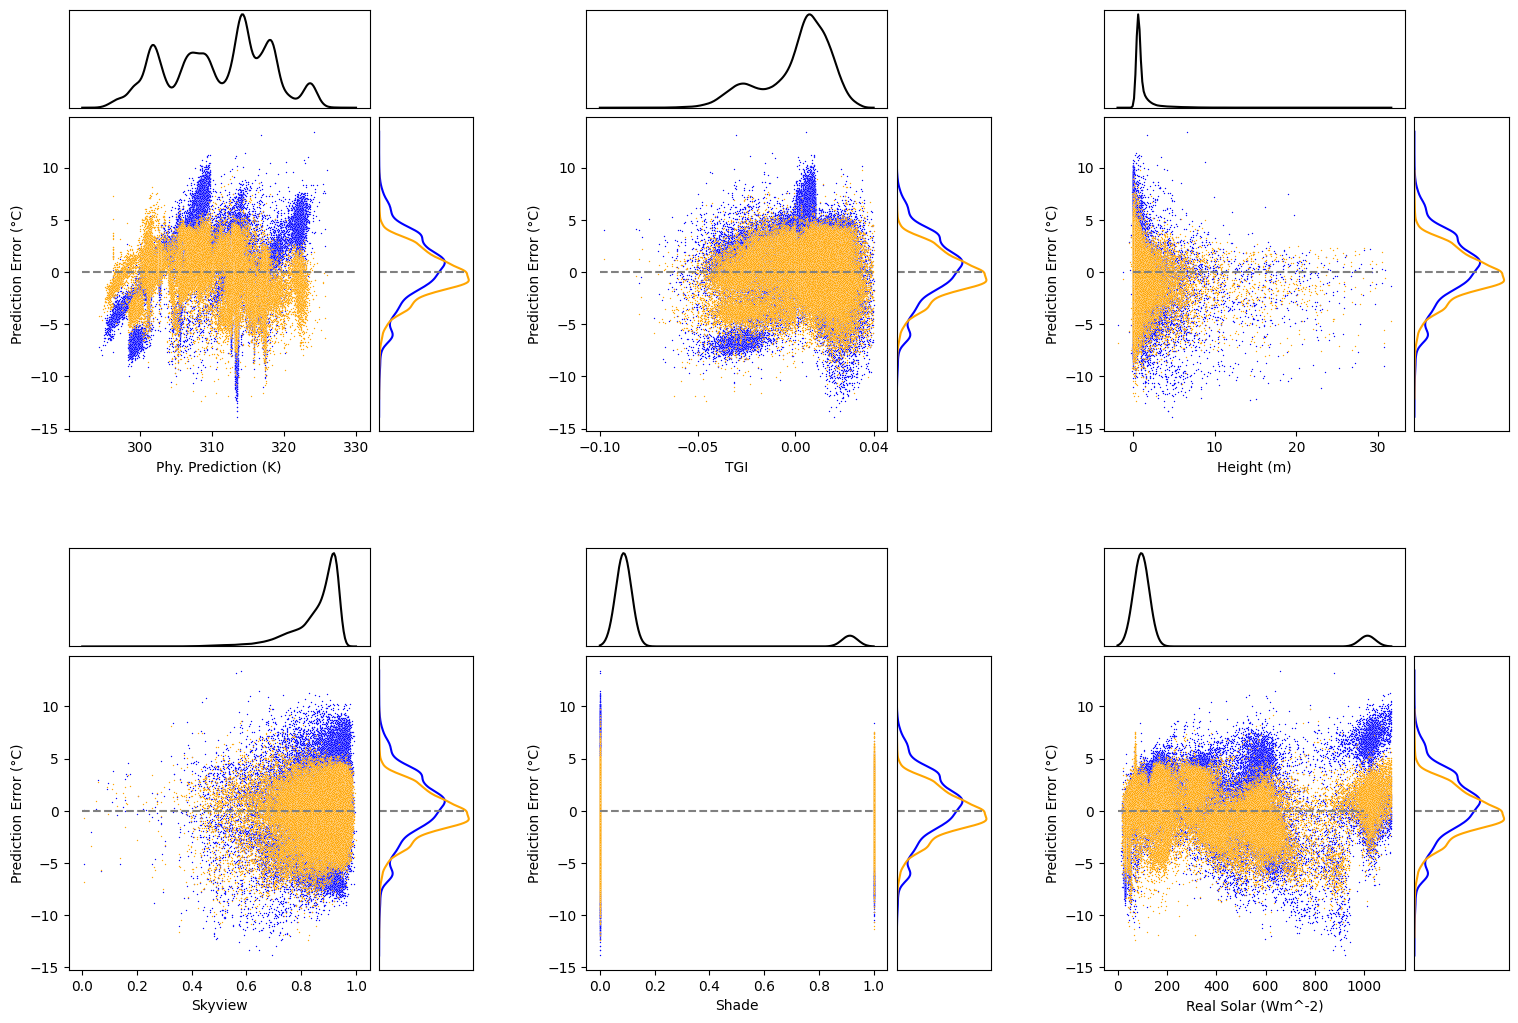

In [10]:
fig = plt.figure(figsize = (18,12))

# Physical prediction
ax11 = plt.subplot2grid((9, 14), (1, 0), colspan=3, rowspan=3)
sns.scatterplot(data = df_map, x = 'Phy', y = 'M1', s = 1, color = 'b', label = 'Physical', ax = ax11, legend = False)
sns.scatterplot(data = df_map, x = 'Phy', y = 'M2', s = 1, color = 'orange', label = 'Statistical', ax = ax11, legend = False)
ax11.set_ylabel(u'Prediction Error (\u00B0C)')
ax11.set_xlabel(u'Phy. Prediction (K)')
ax11.hlines(0, 292, 330, color = 'grey', linestyle = 'dashed')

ax12 = plt.subplot2grid((9, 14), (1, 3), rowspan=3)
sns.kdeplot(data = df_map, y = 'M1', color = 'b', ax = ax12, legend = False)
sns.kdeplot(data = df_map, y = 'M2', color = 'orange', ax = ax12, legend = False)
ax12.set_ylabel('')
ax12.set_yticks([])
ax12.set_xlabel('')
ax12.set_xticks([])
ax12.hlines(0, 0, 0.175, color = 'grey', linestyle = 'dashed')

ax13 = plt.subplot2grid((9, 14), (0,0), colspan=3)
sns.kdeplot(data = df_map, x = 'Phy', color = 'k', ax = ax13, legend = False)
ax13.set_xlabel('')
ax13.set_ylabel('')
ax13.set_xticks([])
ax13.set_yticks([])


# TGI
ax21 = plt.subplot2grid((9, 14), (1, 5), colspan=3, rowspan=3)
sns.scatterplot(data = df_map, x = 'TGI', y = 'M1', s = 1, color = 'b', label = 'Physical', ax = ax21, legend = False)
sns.scatterplot(data = df_map, x = 'TGI', y = 'M2', s = 1, color = 'orange', label = 'Statistical', ax = ax21, legend = False)
ax21.set_ylabel(u'Prediction Error (\u00B0C)')
ax21.set_xlabel('TGI')
ax21.set_xticks([-0.1, -0.05, 0, 0.04])
ax21.hlines(0, -0.1, 0.04, color = 'grey', linestyle = 'dashed')

ax22 = plt.subplot2grid((9, 14), (1, 8), rowspan=3)
sns.kdeplot(data = df_map, y = 'M1', color = 'b', ax = ax22, legend = False)
sns.kdeplot(data = df_map, y = 'M2', color = 'orange', ax = ax22, legend = False)
ax22.set_ylabel('')
ax22.set_yticks([])
ax22.set_xlabel('')
ax22.set_xticks([])
ax22.hlines(0, 0, 0.175, color = 'grey', linestyle = 'dashed')

ax23 = plt.subplot2grid((9, 14), (0,5), colspan=3)
sns.kdeplot(data = df_map, x = 'TGI', color = 'k', ax = ax23, legend = False)
ax23.set_xlabel('')
ax23.set_ylabel('')
ax23.set_xticks([])
ax23.set_yticks([])


# Height
ax31 = plt.subplot2grid((9, 14), (1, 10), colspan=3, rowspan=3)
sns.scatterplot(data = df_map, x = 'Height', y = 'M1', s = 1, color = 'b', label = 'Physical', ax = ax31, legend = False)
sns.scatterplot(data = df_map, x = 'Height', y = 'M2', s = 1, color = 'orange', label = 'Statistical', ax = ax31, legend = False)
ax31.set_ylabel(u'Prediction Error (\u00B0C)')
ax31.set_xlabel('Height (m)')
ax31.hlines(0, 0, 30, color = 'grey', linestyle = 'dashed')

ax32 = plt.subplot2grid((9, 14), (1, 13), rowspan=3)
sns.kdeplot(data = df_map, y = 'M1', color = 'b', ax = ax32, legend = False)
sns.kdeplot(data = df_map, y = 'M2', color = 'orange', ax = ax32, legend = False)
ax32.set_ylabel('')
ax32.set_yticks([])
ax32.set_xlabel('')
ax32.set_xticks([])
ax32.hlines(0, 0, 0.175, color = 'grey', linestyle = 'dashed')

ax33 = plt.subplot2grid((9, 14), (0,10), colspan=3)
sns.kdeplot(data = df_map, x = 'Height', color = 'k', ax = ax33, legend = False)
ax33.set_xlabel('')
ax33.set_ylabel('')
ax33.set_xticks([])
ax33.set_yticks([])


# Skyview
ax41 = plt.subplot2grid((9, 14), (6, 0), colspan=3, rowspan=3)
sns.scatterplot(data = df_map, x = 'Skyview', y = 'M1', s = 1, color = 'b', label = 'Physical', ax = ax41, legend = False)
sns.scatterplot(data = df_map, x = 'Skyview', y = 'M2', s = 1, color = 'orange', label = 'Statistical', ax = ax41, legend = False)
ax41.set_ylabel(u'Prediction Error (\u00B0C)')
ax41.set_xlabel('Skyview')
ax41.hlines(0, 0, 1, color = 'grey', linestyle = 'dashed')

ax42 = plt.subplot2grid((9, 14), (6, 3), rowspan=3)
sns.kdeplot(data = df_map, y = 'M1', color = 'b', ax = ax42, legend = False)
sns.kdeplot(data = df_map, y = 'M2', color = 'orange', ax = ax42, legend = False)
ax42.set_ylabel('')
ax42.set_yticks([])
ax42.set_xlabel('')
ax42.set_xticks([])
ax42.hlines(0, 0, 0.175, color = 'grey', linestyle = 'dashed')

ax43 = plt.subplot2grid((9, 14), (5,0), colspan=3)
sns.kdeplot(data = df_map, x = 'Skyview', color = 'k', ax = ax43, legend = False)
ax43.set_xlabel('')
ax43.set_ylabel('')
ax43.set_xticks([])
ax43.set_yticks([])


# Shade
ax51 = plt.subplot2grid((9, 14), (6, 5), colspan=3, rowspan=3)
sns.scatterplot(data = df_map, x = 'Shade', y = 'M1', s = 1, color = 'b', label = 'Physical', ax = ax51, legend = False)
sns.scatterplot(data = df_map, x = 'Shade', y = 'M2', s = 1, color = 'orange', label = 'Statistical', ax = ax51, legend = False)
ax51.set_ylabel(u'Prediction Error (\u00B0C)')
ax51.set_xlabel('Shade')
ax51.hlines(0, 0, 1, color = 'grey', linestyle = 'dashed')

ax52 = plt.subplot2grid((9, 14), (6, 8), rowspan=3)
sns.kdeplot(data = df_map, y = 'M1', color = 'b', ax = ax52, legend = False)
sns.kdeplot(data = df_map, y = 'M2', color = 'orange', ax = ax52, legend = False)
ax52.set_ylabel('')
ax52.set_yticks([])
ax52.set_xlabel('')
ax52.set_xticks([])
ax52.hlines(0, 0, 0.175, color = 'grey', linestyle = 'dashed')

ax53 = plt.subplot2grid((9, 14), (5,5), colspan=3)
sns.kdeplot(data = df_map, x = 'Shade', color = 'k', ax = ax53, legend = False)
ax53.set_xlabel('')
ax53.set_ylabel('')
ax53.set_xticks([])
ax53.set_yticks([])


# Real Solar
ax61 = plt.subplot2grid((9, 14), (6, 10), colspan=3, rowspan=3)

sns.scatterplot(data = df_map, x = 'RealSolar', y = 'M1', s = 1, color = 'b', label = 'Physical', ax = ax61, legend = False)
sns.scatterplot(data = df_map, x = 'RealSolar', y = 'M2', s = 1, color = 'orange', label = 'Statistical', ax = ax61, legend = False)
ax61.set_ylabel(u'Prediction Error (\u00B0C)')
ax61.set_xlabel('Real Solar (Wm^-2)')
ax61.hlines(0, 0, 1000, color = 'grey', linestyle = 'dashed')

ax62 = plt.subplot2grid((9, 14), (6, 13), rowspan=3)
sns.kdeplot(data = df_map, y = 'M1', color = 'b', ax = ax62, legend = False)
sns.kdeplot(data = df_map, y = 'M2', color = 'orange', ax = ax62, legend = False)
ax62.set_ylabel('')
ax62.set_yticks([])
ax62.set_xlabel('')
ax62.set_xticks([])
ax62.hlines(0, 0, 0.175, color = 'grey', linestyle = 'dashed')

ax63 = plt.subplot2grid((9, 14), (5,10), colspan=3)
sns.kdeplot(data = df_map, x = 'Shade', color = 'k', ax = ax63, legend = False)
ax63.set_xlabel('')
ax63.set_ylabel('')
ax63.set_xticks([])
ax63.set_yticks([])

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)
plt.show()